In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [2]:
with open('/project/gpaa/machine_learning/jainam_capstone/preprocessing/AA_labeled_batches0-16.csv', 'r') as f:
  df_labeled_init_no_liver = pd.read_csv(f)

df_labeled_init_no_liver = df_labeled_init_no_liver.rename(columns={'sample_id': "Run"})

X = df_labeled_init_no_liver.drop(['Run', 'AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

print(df_labeled_init_no_liver.shape)

(243, 13704)


In [3]:
dict_LASSO = {}
dict_random_forest = {}
dict_rfe = {}
dict_union = {}

for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'):

  LASSO_list = []
  random_forest_list = []
  rfe_list = []

  if 'ranked_indices_AA' in filename:

    s = filename.split('_')
    if 'LASSO' in filename:

      with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          LASSO_list.append(gene)

        s = filename.split('_')
        dict_LASSO[int(s[-1][0])] = LASSO_list

    elif 'random_forest' in filename:

        with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:

          df_top80 = pd.read_csv(f, header=None)
        
          top80_list = df_top80[0].values.tolist()
          top80_list = [int(i) for i in top80_list]

          for index in top80_list:
            gene = X.columns[index]
            random_forest_list.append(gene)

          s = filename.split('_')
          dict_random_forest[int(s[-1][0])] = random_forest_list

    elif 'rfe' in filename:
      with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          rfe_list.append(gene)

        s = filename.split('_')
        dict_rfe[int(s[-1][0])] = rfe_list

In [4]:
genes = pd.DataFrame(X.columns.tolist(), columns = ['gene_id'])

In [5]:
genes[['LASSO', 'random_forest', 'rfe']] = 0

In [6]:
for index, gene in genes['gene_id'].items():
    for split, rank_list in dict_LASSO.items():
        genes.loc[genes['gene_id'] == gene, 'LASSO'] += rank_list.index(gene)
    genes.loc[genes['gene_id'] == gene, 'LASSO'] = genes.loc[genes['gene_id'] == gene, 'LASSO'] / len(dict_LASSO) + 1
    
    for split, rank_list in dict_random_forest.items():
        genes.loc[genes['gene_id'] == gene, 'random_forest'] += rank_list.index(gene)
    genes.loc[genes['gene_id'] == gene, 'random_forest'] = genes.loc[genes['gene_id'] == gene, 'random_forest'] / len(dict_random_forest) + 1

    for split, rank_list in dict_rfe.items():
        genes.loc[genes['gene_id'] == gene, 'rfe'] += rank_list.index(gene)
    genes.loc[genes['gene_id'] == gene, 'rfe'] = genes.loc[genes['gene_id'] == gene, 'rfe'] / len(dict_rfe) + 1

KeyboardInterrupt: 

In [ ]:
with open('/project/gpaa/machine_learning/jainam_capstone/differential_expression/noconfound_AA_DE_results.csv', 'r') as f:
  DE = pd.read_csv(f)

In [ ]:
DE[['gene_id', 'gene_name']] = DE["Unnamed: 0"].str.split('|', expand = True)

In [ ]:
DE.drop(columns="Unnamed: 0", inplace = True)

In [ ]:
DE_consistency = pd.merge(DE, genes, on='gene_id', how = 'inner')

In [ ]:
DE_consistency.to_csv("/project/gpaa/machine_learning/jainam_capstone/feature_selection/average_rank_AA.csv", index = False)

In [7]:
with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/average_rank_AA.csv', 'r') as f:
  DE_consistency = pd.read_csv(f)

Text(0, 0.5, '-log(adjusted_P_value)')

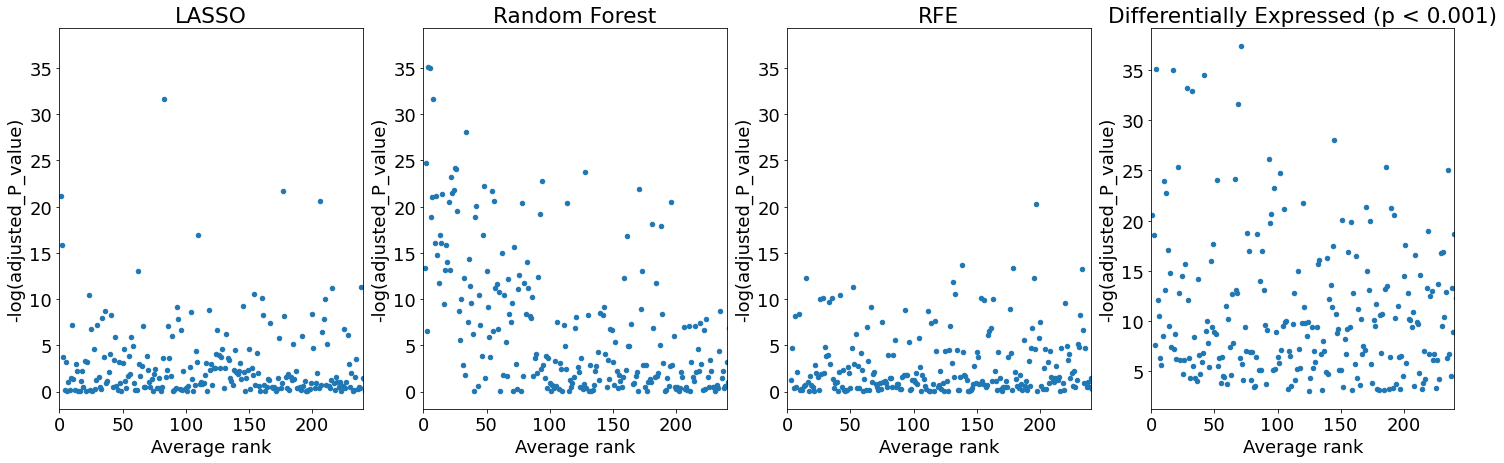

In [11]:
plt.subplots(figsize = (25, 7))
plt.rcParams.update({'font.size': 18})
plt.subplot(1,4,1)
DE_consistency.sort_values(by = "LASSO", inplace = True)
plt.scatter(np.arange(1,DE_consistency.shape[0]+1), -np.log10(DE_consistency['padj']), s = 20)
plt.xlim([0, 240])
plt.title('LASSO')
plt.xlabel('Average rank')
plt.ylabel('-log(adjusted_P_value)')
plt.subplot(1,4,2)
DE_consistency.sort_values(by = "random_forest", inplace = True)
plt.scatter(np.arange(1,DE_consistency.shape[0]+1), -np.log10(DE_consistency['padj']), s = 20)
plt.xlim([0, 240])
plt.title('Random Forest')
plt.xlabel('Average rank')
plt.ylabel('-log(adjusted_P_value)')
plt.subplot(1,4,3)
DE_consistency.sort_values(by = "rfe", inplace = True)
plt.scatter(np.arange(1,DE_consistency.shape[0]+1), -np.log10(DE_consistency['padj']), s = 20)
plt.xlim([0, 240])
plt.title('RFE')
plt.xlabel('Average rank')
plt.ylabel('-log(adjusted_P_value)')
plt.subplot(1,4,4)
DE_genes = DE_consistency.loc[DE_consistency['padj'] < 0.001]
DE_genes = DE_genes.sort_values(by = 'log2FoldChange', key = abs, ascending = False)
plt.scatter(np.arange(1,DE_genes.shape[0]+1), -np.log10(DE_genes['padj']), s = 20)
plt.xlim([0, 240])
plt.title('Differentially Expressed (p < 0.001)')
plt.xlabel('Average rank')
plt.ylabel('-log(adjusted_P_value)')

Text(0, 0.5, 'LogFoldChange')

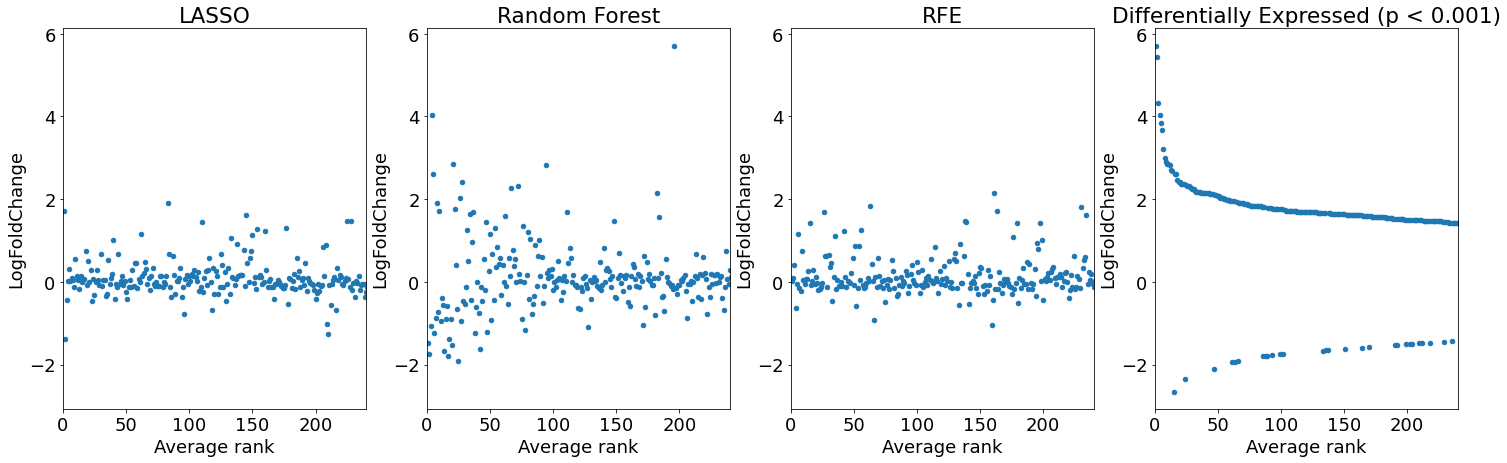

In [13]:
plt.subplots(figsize = (25, 7))
plt.rcParams.update({'font.size': 18})
plt.subplot(1,4,1)
DE_consistency.sort_values(by = "LASSO", inplace = True)
plt.scatter(np.arange(1,DE_consistency.shape[0]+1), DE_consistency['log2FoldChange'], s = 20)
plt.xlim([0, 240])
plt.title('LASSO')
plt.xlabel('Average rank')
plt.ylabel('LogFoldChange')
plt.subplot(1,4,2)
DE_consistency.sort_values(by = "random_forest", inplace = True)
plt.scatter(np.arange(1,DE_consistency.shape[0]+1), DE_consistency['log2FoldChange'], s = 20)
plt.xlim([0, 240])
plt.title('Random Forest')
plt.xlabel('Average rank')
plt.ylabel('LogFoldChange')
plt.subplot(1,4,3)
DE_consistency.sort_values(by = "rfe", inplace = True)
plt.scatter(np.arange(1,DE_consistency.shape[0]+1), DE_consistency['log2FoldChange'], s = 20)
plt.xlim([0, 240])
plt.title('RFE')
plt.xlabel('Average rank')
plt.ylabel('LogFoldChange')
plt.subplot(1,4,4)
DE_genes = DE_consistency.loc[DE_consistency['padj'] < 0.001]
DE_genes = DE_genes.sort_values(by = 'log2FoldChange', key = abs, ascending = False)
plt.scatter(np.arange(1,DE_genes.shape[0]+1), DE_genes['log2FoldChange'], s = 20)
plt.xlim([0, 240])
plt.title('Differentially Expressed (p < 0.001)' )
plt.xlabel('Average rank')
plt.ylabel('LogFoldChange')